In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
import plotly.express as px
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [3]:
df = pd.read_csv('train.tsv',sep='\t')

df = df[['claim','main_text','label']]
df.dropna(axis=0,inplace =True)


In [4]:
stop_words = set(stopwords.words('english'))

df['main_text'] = df['main_text'].apply(lambda x: re.sub(r'[#\\\"$”“,:()–’\'/;\[\]{}—‘!+•%&-]', ' ', x))
df['main_text'] = df['main_text'].apply(lambda x: re.sub(r'\s+', ' ', x))
df['main_text'] = df['main_text'].apply(lambda x: x.lower())
df['main_text'] = df['main_text'].apply(lambda x: ' '.join([word for word in word_tokenize(x) if word.lower() not in stop_words]))

df['claim'] = df['claim'].apply(lambda x: re.sub(r'[#\\\"$”“,:()–’\'/;\[\]{}—‘!+•%&-]',' ',x))
df['claim'] = df['claim'].apply(lambda x: re.sub(r'\s+',' ',x))
df['claim'] = df['claim'].apply(lambda x: x.lower())
df['claim'] = df['claim'].apply(lambda x: ' '.join([word for word in word_tokenize(x) if word.lower() not in stop_words]))

df1 = df[~df['label'].isin(['snopes'])]
df1.shape,df.shape

((9804, 3), (9805, 3))

In [5]:
n = len(set(df1['main_text']))
corpus = list(set(df1['main_text']))+list(set(df1['claim'])) # corpus to fit the vectorizer on

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer # inbuilt function for BOWs

vectorizer = CountVectorizer(max_features=5000)
X = vectorizer.fit_transform(corpus)
len(vectorizer.get_feature_names_out())

In [5]:
import torch
from transformers import AutoTokenizer
from transformers import DistilBertForSequenceClassification

In [6]:
def get_input_and_attention(df, tokenizer):
  input_ids_list = []
  attention_masks_list = []
  token_type_ids_list = []
  for index, row in df.iterrows():
      sentence_a = row['main_text']
      sentence_b = row['claim']

      inputs = tokenizer(sentence_a, sentence_b, padding='max_length', truncation=True, return_tensors='pt')

      input_ids = inputs['input_ids'].squeeze(0)
      attention_mask = inputs['attention_mask'].squeeze(0) # this might change for other models
      token_type_ids = inputs.get('token_type_ids', None) #ignore this part

      input_ids_list.append(input_ids)
      attention_masks_list.append(attention_mask)
  input_ids = torch.stack(input_ids_list, dim=0) #converting list to tensor object
  attention_masks = torch.stack(attention_masks_list, dim=0)
  return input_ids, attention_masks

In [7]:
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoModel

class TransformerClassifier(nn.Module):
    def __init__(self, transformer_name, num_classes=4, dropout_prob=0.3, random_state=42):
        super(TransformerClassifier, self).__init__()
        # Load pre-trained transformer model
        self.transformer = AutoModel.from_pretrained(transformer_name)

        # Random seed for reproducibility
        torch.manual_seed(random_state)

        # Dropout layer
        self.dropout = nn.Dropout(p=dropout_prob)

        # Fully connected layers
        self.fc1 = nn.Linear(self.transformer.config.hidden_size, 512)
        self.fc2 = nn.Linear(512, num_classes)

        # Activation
        self.relu = nn.ReLU()

        # Softmax for output
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_ids, attention_mask):
        # Pass inputs through the transformer
        transformer_outputs = self.transformer(input_ids=input_ids, attention_mask=attention_mask)

        # Extract the CLS token output (first token of each sequence)
        cls_token_output = transformer_outputs.last_hidden_state[:, 0, :]

        # Apply dropout
        x = self.dropout(cls_token_output)

        # Pass through fully connected layers
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        # Apply softmax to get probabilities
        probs = self.softmax(x)
        return probs
    def loss_fn(self,y,y_pred):
        log_pred = torch.log(y_pred+1e-8)
        loss = -(log_pred*y).sum(1).mean()
        return loss


In [8]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

#bertModel = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=4)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [10]:
bert_model = TransformerClassifier('distilbert-base-uncased')

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [11]:
print(bert_model)

TransformerClassifier(
  (transformer): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (

In [12]:
input_ids_train, attention_masks_train = get_input_and_attention(df1, tokenizer)
#input_ids_test, attention_masks_test = get_input_and_attention(df_test, tokenizer)

In [24]:
len(df1['main_text'].iloc[2].split())

525

In [37]:
input_ids_train.shape

torch.Size([9804, 512])

In [39]:
sum([x==102 for x in input_ids_train[9]])!=2

tensor(False)

In [41]:
l =[]
for i in range(input_ids_train.shape[0]):
    if sum([x==102 for x in input_ids_train[i]])!=2:
        l.append(i)

In [42]:
l

[]

In [17]:
len(('hi there').split())

2

In [18]:
max([len(x.split()) for x in (df1['main_text'].values)])

4356

In [28]:
df1['label']

,label
0,false
1,mixture
2,mixture
3,true
4,true
...,...
9827,unproven
9828,true
9829,true
9830,false


In [13]:
train_labels = df1['label']
# Map string labels to integers
label_mapping = {'true': 0, 'false': 1, 'mixture': 2,'unproven':3}
y_train = train_labels.map(label_mapping)

In [14]:
y_train.values

array([1, 2, 2, ..., 0, 1, 1])

In [15]:
y_train = torch.tensor(y_train.values, dtype=torch.long)

#y_test = torch.tensor(df_test['label'].values)

In [1]:
y_train

NameError: name 'y_train' is not defined

In [17]:
from torch.utils.data import TensorDataset, DataLoader
from torch import optim
#from sklearn.model_selection import train_test_split
train_dataset = TensorDataset(input_ids_train, attention_masks_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [ ]:
lr = 0.001 # this is our base learning rate
epochs = 20


optimizer = optim.Adam(bert_model.parameters(), lr=lr)

# set model to training mode
bert_model.train()

for epoch in range(epochs):
    for inputid_batch, attention_batch,y_batch in train_loader:

        y_batch = F.one_hot(y_batch, num_classes=4) # turn digit labels into one-hot vectors 5 -> (0,0,0,0,0,1,0,0,0,0)
        y_pred = bert_model(inputid_batch,attention_batch) # this is from our forward function
        print(f'y_batch :{y_batch},y_pred :{y_pred}')
        #loss = model.loss_fn(y_batch, y_pred)
        loss = bert_model.loss_fn(y_batch, y_pred)
        loss.backward() # calculates the gradients using backpropogation
        optimizer.step() # take a gradient step for our parameters
        optimizer.zero_grad() # set gradients back to zero

    if epoch % 1 == 0:
        print('epoch: ', epoch, 'loss:', f"{loss.item():.3}")

In [5]:
import torch
from transformers import AutoTokenizer, AutoModel
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch import optim

# Define the model
class TransformerClassifier(nn.Module):
    def __init__(self, transformer_name, num_classes=4, dropout_prob=0.3):
        super(TransformerClassifier, self).__init__()
        self.transformer = AutoModel.from_pretrained(transformer_name)
        self.dropout = nn.Dropout(p=dropout_prob)
        self.fc1 = nn.Linear(self.transformer.config.hidden_size, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()

    def forward(self, input_ids, attention_mask):
        transformer_outputs = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        cls_token_output = transformer_outputs.last_hidden_state[:, 0, :]  # CLS token
        x = self.dropout(cls_token_output)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)  # Output logits
        return x  # Return logits, softmax is applied in loss computation

    def loss_fn(self, y, y_pred):
        return nn.CrossEntropyLoss()(y_pred, y)

# Prepare the tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Data Preparation Function
def get_input_and_attention(df, tokenizer):
    input_ids_list, attention_masks_list = [], []
    for _, row in df.iterrows():
        inputs = tokenizer(
            row['main_text'], row['claim'],
            padding='max_length', truncation=True, return_tensors='pt', max_length=128
        )
        input_ids_list.append(inputs['input_ids'].squeeze(0))
        attention_masks_list.append(inputs['attention_mask'].squeeze(0))
    return torch.stack(input_ids_list), torch.stack(attention_masks_list)

# Load data and labels
input_ids_train, attention_masks_train = get_input_and_attention(df1, tokenizer)
label_mapping = {'true': 0, 'false': 1, 'mixture': 2, 'unproven': 3}
y_train = torch.tensor(df1['label'].map(label_mapping).values, dtype=torch.long)

# Create Dataset and DataLoader
train_dataset = TensorDataset(input_ids_train, attention_masks_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Initialize model, optimizer, and move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransformerClassifier('distilbert-base-uncased', num_classes=4).to(device)
optimizer = optim.Adam(model.parameters(), lr=5e-5)

# Training Loop
epochs = 3
model.train()
for epoch in range(epochs):
    total_loss = 0
    for input_ids_batch, attention_mask_batch, y_batch in train_loader:
        input_ids_batch = input_ids_batch.to(device)
        attention_mask_batch = attention_mask_batch.to(device)
        y_batch = y_batch.to(device)

        # Forward pass
        logits = model(input_ids_batch, attention_mask_batch)

        # Loss computation
        loss = model.loss_fn(y_batch, logits)
        total_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Epoch 1/3, Loss: 0.8805
Epoch 2/3, Loss: 0.7189
Epoch 3/3, Loss: 0.5794


In [7]:
test_df = pd.read_csv('test.tsv',sep='\t')
test_df = test_df[['claim','main_text','label']]
test_df.dropna(axis=0,inplace =True)

In [9]:
stop_words = set(stopwords.words('english'))

test_df['main_text'] = test_df['main_text'].apply(lambda x: re.sub(r'[#\\\"$”“,:()–’\'/;\[\]{}—‘!+•%&-]', ' ', x))
test_df['main_text'] = test_df['main_text'].apply(lambda x: re.sub(r'\s+', ' ', x))
test_df['main_text'] = test_df['main_text'].apply(lambda x: x.lower())
test_df['main_text'] = test_df['main_text'].apply(lambda x: ' '.join([word for word in word_tokenize(x) if word.lower() not in stop_words]))

test_df['claim'] = test_df['claim'].apply(lambda x: re.sub(r'[#\\\"$”“,:()–’\'/;\[\]{}—‘!+•%&-]',' ',x))
test_df['claim'] = test_df['claim'].apply(lambda x: re.sub(r'\s+',' ',x))
test_df['claim'] = test_df['claim'].apply(lambda x: x.lower())
test_df['claim'] = test_df['claim'].apply(lambda x: ' '.join([word for word in word_tokenize(x) if word.lower() not in stop_words]))

test_df1 = test_df[~test_df['label'].isin(['snopes'])]
test_df1.shape,test_df.shape

((1233, 3), (1233, 3))

In [10]:
input_ids_test, attention_masks_test = get_input_and_attention(test_df1, tokenizer)
label_mapping = {'true': 0, 'false': 1, 'mixture': 2, 'unproven': 3}
y_test = torch.tensor(test_df1['label'].map(label_mapping).values, dtype=torch.long)

In [13]:
# Move input tensors to the same device as the model
input_ids_test = input_ids_test.to(device)
attention_masks_test = attention_masks_test.to(device)

In [14]:
model.eval()

# Perform inference
with torch.no_grad():  # Disable gradient computation for inference
    predictions = model(input_ids_test, attention_masks_test)

# Convert logits to probabilities and then to predicted labels
predicted_labels = torch.argmax(predictions, dim=1).cpu().numpy()

In [19]:
predicted_labels

array([1, 0, 1, ..., 1, 0, 0])

In [18]:
y_test

tensor([1, 0, 0,  ..., 1, 0, 0])

In [20]:
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, f1_score,  recall_score

In [23]:
accuracy = accuracy_score(y_test, predicted_labels)
macro_precision = precision_score(y_test, predicted_labels, average='macro')
macro_recall = recall_score(y_test, predicted_labels, average='macro')
f1 = f1_score(y_test, predicted_labels, average='weighted')

metrics = ['Accuracy', 'Macro Precision', 'Macro Recall', 'F1 Score']
values = [accuracy, macro_precision, macro_recall, f1]
fig = px.bar(x=metrics, y=values, text=np.round(values, 4),
             labels={'x': 'Metrics', 'y': 'Values'},
             title='Evaluation Metrics',
             template='plotly_white',
              color=values,
             color_continuous_scale='Viridis',
              color_continuous_midpoint=None
             )

fig.update_layout(yaxis=dict(range=[0, 1]))

fig.show()

Text(34.472222222222214, 0.5, 'Predicted Label')

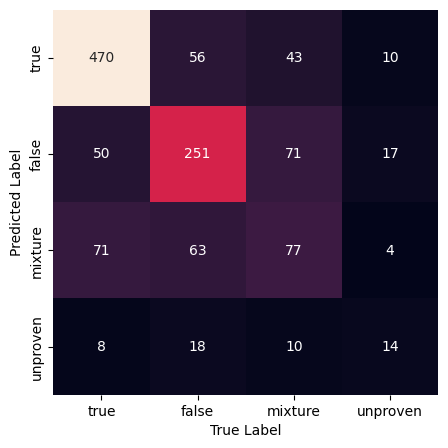

In [22]:

class_labels = ['true','false','mixture','unproven']
mat = confusion_matrix(y_test, predicted_labels)
plt.figure(figsize=(5,5))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('True Label')
plt.ylabel('Predicted Label')